In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt

from flax import nnx

from neuralbridge.sdes.examples import OUSDE, OUBridgeSDE
from neuralbridge.sdes.base import AuxiliarySDE, GuidedProposalSDE
from neuralbridge.sdes.solver import SDESolver
from neuralbridge.utils.pcn import PCNSampler

In [4]:
sigma = jnp.array([[0.2, 0.1], [0.3, 0.2]])
T = 4.0
n_steps = 1000
ts = jnp.linspace(0.0, T, n_steps)

sde = OUSDE(
    dim_x=2,
    dim_w=2,
    params={
        'gamma': - jnp.eye(2),
        'mu': - jnp.zeros(2),
        'sigma': sigma
    }
)

aux_sde = AuxiliarySDE(
    dim_x=2,
    dim_w=2,
    coeffs={
        'T': T,
        'beta': lambda t: jnp.zeros(2),
        'B': lambda t: jnp.zeros((2, 2)),
        'a_tilde_0': None,
        'a_tilde_T': sigma @ sigma.T
    }
)

eps = 1e-5

obs_params = {
    'vT': jnp.ones(2),
    'LT': jnp.eye(2),
    'SigmaT': eps**2 * jnp.eye(2)
}

gp_sde = GuidedProposalSDE(
    sde=sde,
    aux_sde=aux_sde,
    obs_params=obs_params,
    ts=ts,
    eq_type='uLM'
)

In [8]:
def plot(traj, ts):
    fig, axes = plt.subplots(2, 1, figsize=(10, 8))
    for i in range(traj.shape[0]):
        axes[0].plot(ts, traj[i, :, 0], color='blue')
        axes[1].plot(ts, traj[i, :, 1], color='red')
    plt.show()

In [5]:
rng_key = jr.PRNGKey(0)
x0 = jnp.zeros(2)

gp_solver = SDESolver(gp_sde, method='euler')

gp_trajs = gp_solver.batch_solve(rng_key, x0, ts, 10)

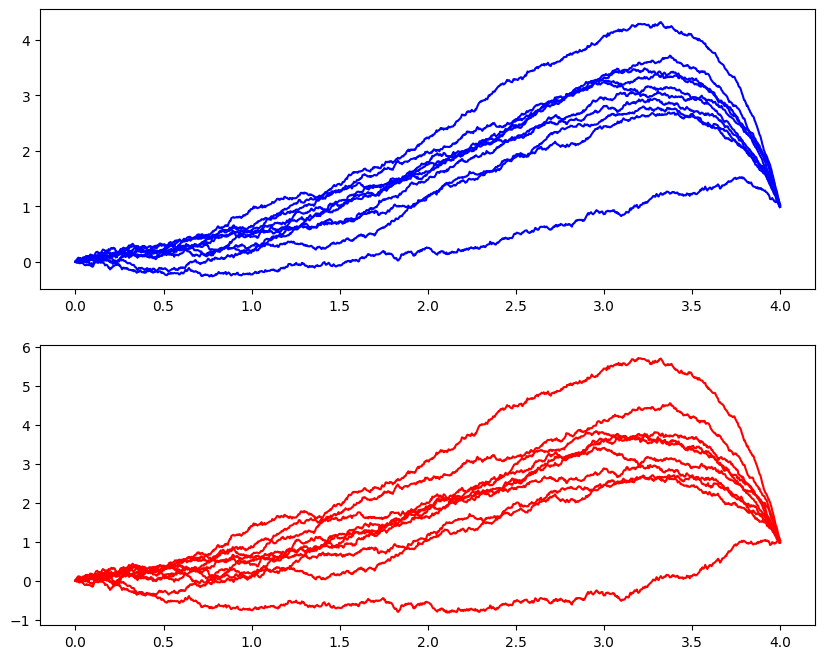

In [9]:
plot(gp_trajs, ts)

In [12]:
pcn_sampler = PCNSampler(gp_sde, eta=0.9)

pcn_trajs, lls = pcn_sampler.sample(
    x0, ts, n_iters=10000, n_samples=10, n_burn_in=5000, rng_key=rng_key
)

100%|██████████| 10000/10000 [00:12<00:00, 805.17it/s]

acceptance rate (post-burn-in): 0.20%


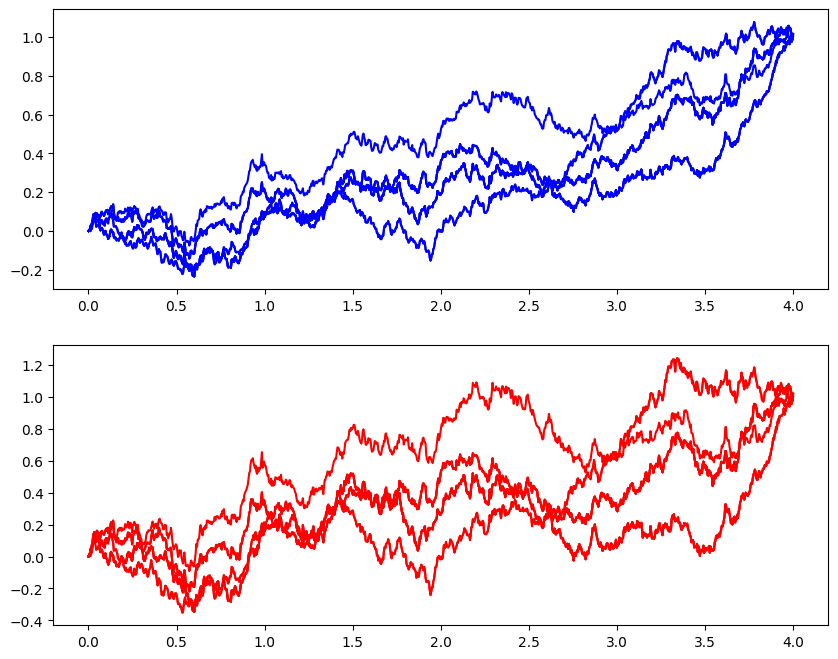

In [13]:
plot(pcn_trajs, ts)

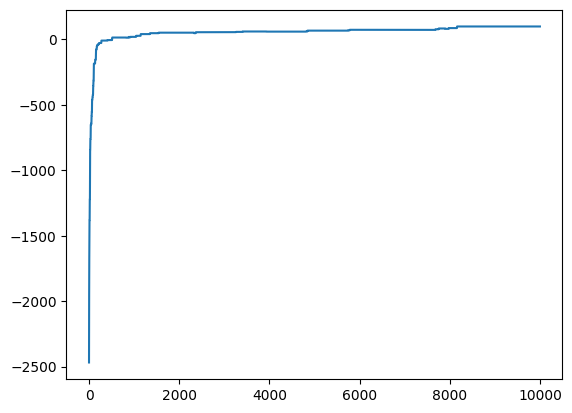

In [14]:
plt.plot(lls)

In [28]:
Gs = jax.vmap(gp_sde.G, in_axes=(0, None))(ts, 0.5 *jnp.ones(2))
print(Gs.shape)

(1000,)


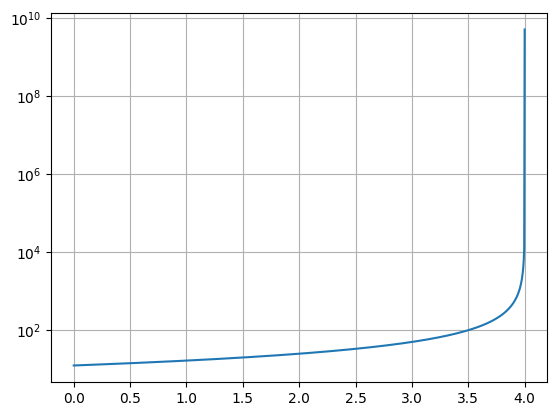

In [32]:
plt.plot(ts, Gs)
plt.yscale('log')
plt.grid()